In [12]:
# %% [code]
# Cell 1: Imports & global setup

import os, sys, random
import numpy as np
import torch
import torch.optim as optim
import urllib3
import matplotlib.pyplot as plt
from debug_utils import debug_print

# %% [code]
from torch.utils.tensorboard import SummaryWriter

tb_logdir = "runs/selfplay_experiment"
writer = SummaryWriter(tb_logdir)
writer.add_scalar("init/ready", 0, 0)
writer.flush()

debug_print(f"TensorBoard logs will be written to {tb_logdir}")



# Add project root so we can import game/ai modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Replay & model utilities
from api.replay import build_replay_experiences
from experiment import build_action_rep_for_state
from api.playSlumbot import ChooseActionAI, STACK_SIZE, BIG_BLIND, SMALL_BLIND
from siamese_net import PseudoSiameseNet, logits_to_probs, clone_model_weights, to_torch_input
from ppo_utils import a_gae, tc_loss_function, ratio, r_gamma, v_loss, make_model_value_function
from hand_result import create_hands_from_experiences, build_experiences_from_txt

# In-memory game
from game.game import PokerGame
from game.player import Player

# Device selection
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps"   if torch.backends.mps.is_available()
                      else "cpu")
debug_print("Using device:", device)


In [13]:
# %% [code]
# Cell 2: AgentEntry, helpers, self-play routines

INITIAL_ELO = 1500

class AgentEntry:
    def __init__(self, policy_net=None, elo=INITIAL_ELO, strategy=None):
        self.policy_net = policy_net.to(device) if policy_net else PseudoSiameseNet().to(device)
        self.elo = elo
        self.strategy = strategy

def expected_score(rA, rB): 
    return 1 / (1 + 10 ** ((rB - rA) / 400))

def update_elo(r, exp, score, k=32):
    return r + k * (score - exp)

def initialize_agent():
    net = PseudoSiameseNet().to(device)
    return AgentEntry(net, INITIAL_ELO)

def convert_card(card_str):
    rk, _, st = card_str.partition(" of ")
    rk = "T" if rk=="10" else (rk[0].upper() if not rk.isdigit() else rk)
    return rk + st[0].lower()

def construct_parsed_state(game, client_pos, action_history):
    # map your stages to 0..3
    stage_map = {
        'pre_flop': 0,
        'flop':     1,
        'turn':     2,
        'river':    3,
        'showdown': 3,
        'complete': 3
    }
    st = stage_map.get(game.stage, 3)

    # hero and villain current‐street contributions:
    hero = game.players[client_pos]
    opp  = game.players[1-client_pos]
    hero_st = hero.current_bet
    vill_st = opp.current_bet

    return {
        'action_str':  action_history,      # full "/"‐separated history so far
        'hero_street': hero_st,             # *** was 0 before! ***
        'vill_street': vill_st,             # *** was 0 before! ***
        'pot_total':   game.pot,            # total in pot (all streets)
        'street':      st,
        'next_to_act': game.current_player_index,
        'error':       None,
        'hand_over':   (game.stage == 'complete')
    }

def translate_move(mv):
    if mv=='f': return 'fold',0
    if mv=='k': return 'check',0
    if mv=='c': return 'call',0
    if mv.startswith('b'): return 'bet', int(mv[1:])
    return 'check',0

def simulate_hand_policy(game: PokerGame, agentA: AgentEntry, agentB: AgentEntry):
    """
    Plays exactly one round on `game` (you must have called game.start_new_round() already).
    Returns (chip_diff, history_string, final_board, final_hole_cards).
    """
    s0      = STACK_SIZE
    history = ""

    # Loop until showdown
    while game.stage != 'complete':
        cp     = game.current_player_index
        ps     = construct_parsed_state(game, cp, history)
        hole   = [convert_card(str(c)) for c in game.players[cp].hand.cards]
        board  = [convert_card(str(c)) for c in game.community_cards]

        agent = agentA if cp == 0 else agentB
        if agent.strategy is not None:
            mv = agent.strategy(game, cp)
        else:
            mv = ChooseActionAI(ps, hole, board, cp, agent.policy_net, device=device) or 'k'

        history += mv
        act, amt = translate_move(mv)
        
        game.handle_action(game.players[cp], act, amt)

        if game.should_move_to_next_stage():
            game.next_stage()
            if game.stage == 'showdown':
                # at showdown, we need to reveal the hands
                game.end_round()
                break
            history += "/"

    # at this point all cards have been dealt
    final_board = [convert_card(str(c)) for c in game.community_cards]
    final_hole  = [convert_card(str(c)) for c in game.players[0].hand.cards]
    diff        = game.players[0].stack - s0

    return diff, history, final_board, final_hole


from game.game import PokerGame
from game.player import Player

def self_play_batch(num_hands, agentA: AgentEntry, agentB: AgentEntry,
                    replay_path="replay.txt"):
    """
    Writes Slumbot-style lines:
      hand_i,history,board,hole_cards,client_pos,winnings
    Returns (total_
    , all_exps).
    """
    # prepare the table and players only once
    A = Player("AgentA", STACK_SIZE)
    B = Player("AgentB", STACK_SIZE)
    game = PokerGame(A, B)

    # clear old file
    open(replay_path, "w").close()

    total_diff = 0
    all_exps   = []
    hand_idx   = 0

    for h in range(1, num_hands + 1):
        hand_idx += 1
        game.start_new_round()


        #get position of playerA
        hero_pos = 1 if game.dealer == A else 0

        # simulate one hand
        diff, hist, board, hole = simulate_hand_policy(game, agentA, agentB)
        total_diff += diff

        # build training exps
        exps, _, _, _ = build_replay_experiences(hist, board, hole, hero_pos, diff)

        debug_print(f"Hand {h}/{num_hands}: diff={diff}, history={hist}")
        for e in exps:
            e['winnings'] = diff
            e['hand_index'] = hand_idx
            
        all_exps.extend(exps)

        # write the exact line Slumbot pipeline expects
        with open(replay_path, "a") as f:
            f.write(f"{h},{hist},{board},{hole},{hero_pos},{diff}\n")

    avg_bb = total_diff / (num_hands * BIG_BLIND)
    debug_print(f"Done: total {total_diff}, mBB/hand {avg_bb:.3f}")
    return total_diff, all_exps


In [14]:
def play_batch(num_hands, policy_entry: AgentEntry, replay_path="replay.txt"):
    """
    Plays `num_hands` of agent vs itself, writes replay.txt,
    and returns (total_winnings, avg_mBB/hand).
    """
    total_diff, _ = self_play_batch(num_hands, policy_entry, policy_entry, replay_path)
    avg_bb = total_diff / (num_hands * BIG_BLIND)
    debug_print(f"\nplay_batch: total_winnings={total_diff}, mBB/hand={avg_bb:.3f}")
    return total_diff, avg_bb


def run_one_iteration(i, rounds_array, old_net, new_net, opt):
    debug_print(f"\n=== PPO iter {i} ===")
    total_pol, total_val, steps = 0.0, 0.0, 0
    model_val = make_model_value_function(new_net)
    states, rewards = zip(*[(r["state"], r["reward"]) for r in rounds_array])
    debug_print(f"  {len(rounds_array)} rounds, {len(states)} states, {len(rewards)} rewards")
    debug_print("Show all rewards:", rewards)

    for j, r in enumerate(rounds_array):
        deltas = r['deltas']; at = r['action_taken']; st = r['state']
        if j < len(rounds_array)-1:
            adv = a_gae(states[j:], rewards[j:], model_val, gamma=0.999, lambda_=0.99)
        else:
            adv = torch.tensor(0.0, device=device)

        act_t, card_t = to_torch_input(st[0], st[1], device)
        with torch.no_grad():
            old_logits,_ = old_net(act_t, card_t)
        old_p = logits_to_probs(old_logits)[0].cpu().numpy()

        new_logits, new_val = new_net(act_t, card_t)
        new_p = logits_to_probs(new_logits)[0].detach().cpu().numpy()

        ratio_t = ratio(old_p, new_p, at)
        pol_loss = tc_loss_function(ratio_t, adv, epsilon=0.2)
        val_loss = v_loss(r_gamma(np.array([r["reward"]]), gamma=0.999), st, deltas, new_val)/(1000*BIG_BLIND)

        loss = -pol_loss + val_loss
        opt.zero_grad(); loss.backward(); opt.step()

        total_pol += pol_loss.item()
        total_val += val_loss.item()
        steps += 1
        debug_print(f"  round {j}: pol={pol_loss.item():.3f}, val={val_loss.item():.3f}")

    return total_pol/steps, total_val/steps, steps

def train_model(model, hand_results):
    old_net = PseudoSiameseNet().to(device)
    new_net = PseudoSiameseNet().to(device)
    clone_model_weights(model, old_net)
    clone_model_weights(model, new_net)

    opt = optim.Adam(new_net.parameters(), lr=1e-5)
    tot_pol, tot_val, tot_steps = 0.0, 0.0, 0

    for idx, hr in enumerate(hand_results):
        avg_pol, avg_val, steps = run_one_iteration(idx, hr.rounds, old_net, new_net, opt)
        tot_pol += avg_pol*steps
        tot_val += avg_val*steps
        tot_steps += steps

    clone_model_weights(new_net, old_net)
    return new_net, (tot_pol/tot_steps), (tot_val/tot_steps)


In [15]:
import random

def random_strategy(game, cp):
    """
    Pick uniformly among legal moves:
      - if there’s a bet_to_match, {call, fold}
      - else {check, bet(BB)}
    """
    player = game.players[cp]
    to_call = game.bets_to_match - player.current_bet

    legal = []
    if to_call > 0:
        if player.stack > to_call:
            legal.append("c")    # call
        else:
            legal.append(f"b{player.stack}")  # call all-in
        legal.append("f")        # fold
    else:
        legal.append("k")        # check
        if player.stack > 0:
            # small “probe” bet of size BIG_BLIND or remaining stack
            amt = min(player.stack, BIG_BLIND)
            legal.append(f"b{amt}")
    return random.choice(legal)


def fold_strategy(game, cp):
    # always fold (legal except when no bet outstanding, in which case fold==check)
    player = game.players[cp]
    if game.bets_to_match > player.current_bet:
        return "f"
    else:
        return "k"


def allin_strategy(game, cp):
    """
    Always go all‐in.  We just bet our entire stack.
    """
    player = game.players[cp]
    total = player.current_bet + player.stack
    return f"b{total}"

def make_static_agents():
    """Return three toy opponents whose `strategy` field is set."""
    return [
        AgentEntry(policy_net=None, elo=INITIAL_ELO, strategy=random_strategy),
        # AgentEntry(policy_net=None, elo=INITIAL_ELO, strategy=fold_strategy),
        AgentEntry(policy_net=None, elo=INITIAL_ELO, strategy=allin_strategy),
    ]

def select_opponent(pool, static_agents, K=5):
    """
    Always keep the static_agents in the draw, and pick one of:
     - any of the static_agents
     - or one of the top-K *learned* agents by Elo
    """
    # learned agents are those with no `strategy`
    learned = [a for a in pool if a.strategy is None]
    top_k   = sorted(learned, key=lambda e: e.elo, reverse=True)[:K]
    # combine top-K learned + all static
    candidates = top_k + static_agents
    return random.choice(candidates)


In [16]:
# %%capture
from collections import deque
from copy import deepcopy

current_agent = initialize_agent()
history_pool   = [deepcopy(current_agent)]
static_agents  = make_static_agents()

num_cycles        = 200
match_hands       = 5000
matches_per_cycle = 1

# ─── New: fixed-size replay buffer & PPO minibatch config ──────────────────
REPLAY_BUFFER = deque(maxlen=10000)   # keep only the most recent 50k transitions
BATCH_SIZE    = 256                   # size of each PPO minibatch
NUM_EPOCHS    =   4                    # number of PPO epochs per cycle
# ─────────────────────────────────────────────────────────────────────────

avg_bb_list   = []
avg_pol_loss  = []
avg_val_loss  = []
elo_history   = []
cycle_numbers = []

# def select_opponent(pool, K=5):
#     top_k = sorted(pool, key=lambda e: e.elo, reverse=True)[:K]
#     return random.choice(top_k)

for cycle in range(1, num_cycles + 1):
    debug_print(f"\n=== Cycle {cycle}/{num_cycles} ===")
    opp = select_opponent(history_pool, static_agents, K=5)

    if opp.strategy is not None:
        debug_print(f"→ Opponent strategy: {opp.strategy.__name__}")

    all_experiences = []
    diffs = []
    for m in range(matches_per_cycle):
        total_diff, exps = self_play_batch(match_hands, current_agent, opp)
        diffs.append(total_diff)
        for e in exps:
            REPLAY_BUFFER.append(e)  # add to replay buffer

    avg_diff = np.mean(diffs)
    mbb = avg_diff / (BIG_BLIND * match_hands * 1000)
    avg_bb_list.append(mbb)
    debug_print(f"→ avg mBB/hand vs Opponent = {mbb:.3f}")
    debug_print(f"→ avg diff = {avg_diff:.1f} chips")

    # Elo update
    if   avg_diff >=  1000: result = 1.0
    elif avg_diff <= -1000: result = 0.0
    else:                result = 0.5

    Rc = current_agent.elo
    Ro = opp.elo
    Ec = expected_score(Rc, Ro)
    current_agent.elo = update_elo(Rc, Ec, result)
    opp.elo          = update_elo(Ro, 1 - Ec, 1 - result)
    elo_history.append(current_agent.elo)
    debug_print(f"→ new Elo: current = {current_agent.elo:.1f}, opponent = {opp.elo:.1f}")

    # Train on everything we just played
    # hand_results = create_hands_from_experiences(all_experiences)
    # debug_print(f"Training on {len(hand_results)} hands of data")
    # new_net, pol_loss, val_loss = train_model(current_agent.policy_net, hand_results)
    minibatch = random.sample(REPLAY_BUFFER, BATCH_SIZE)
    hand_results = create_hands_from_experiences(minibatch)
    new_net, pol_loss, val_loss = train_model(
        current_agent.policy_net,
        hand_results,
        # epochs=NUM_EPOCHS
    )


    avg_pol_loss.append(pol_loss)
    avg_val_loss.append(val_loss)
    debug_print(f"→ policy loss = {pol_loss:.3f}, value loss = {val_loss:.3f}")

    # Snapshot main agent into the pool
    current_agent.policy_net = new_net
    history_pool.append(AgentEntry(deepcopy(new_net), current_agent.elo))

    #make sure we never have over 5 historical agents,
    #if we do remove lowest elo ones
    if len(history_pool) > 3:
        history_pool.sort(key=lambda e: e.elo, reverse=True)
        history_pool = history_pool[:3]

    cycle_numbers.append(cycle)

    writer.add_scalar("Elo/current",    current_agent.elo, cycle)
    writer.add_scalar("mBB/hand",       mbb,             cycle)
    writer.add_scalar("Loss/policy",    pol_loss,        cycle)
    writer.add_scalar("Loss/value",     val_loss,        cycle)

    # (optional) if you want to track the size of your history pool:
    writer.add_scalar("Pool/size",      len(history_pool), cycle)
    writer.flush()

# Plot
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(cycle_numbers, avg_bb_list,   marker='o'); plt.title("avg mBB/hand vs Opponent")
plt.subplot(2,2,2)
plt.plot(cycle_numbers, elo_history,   marker='o'); plt.title("Current Agent Elo")
plt.subplot(2,2,3)
plt.plot(cycle_numbers, avg_pol_loss,  marker='o'); plt.title("Policy Loss")
plt.subplot(2,2,4)
plt.plot(cycle_numbers, avg_val_loss,  marker='o'); plt.title("Value Loss")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

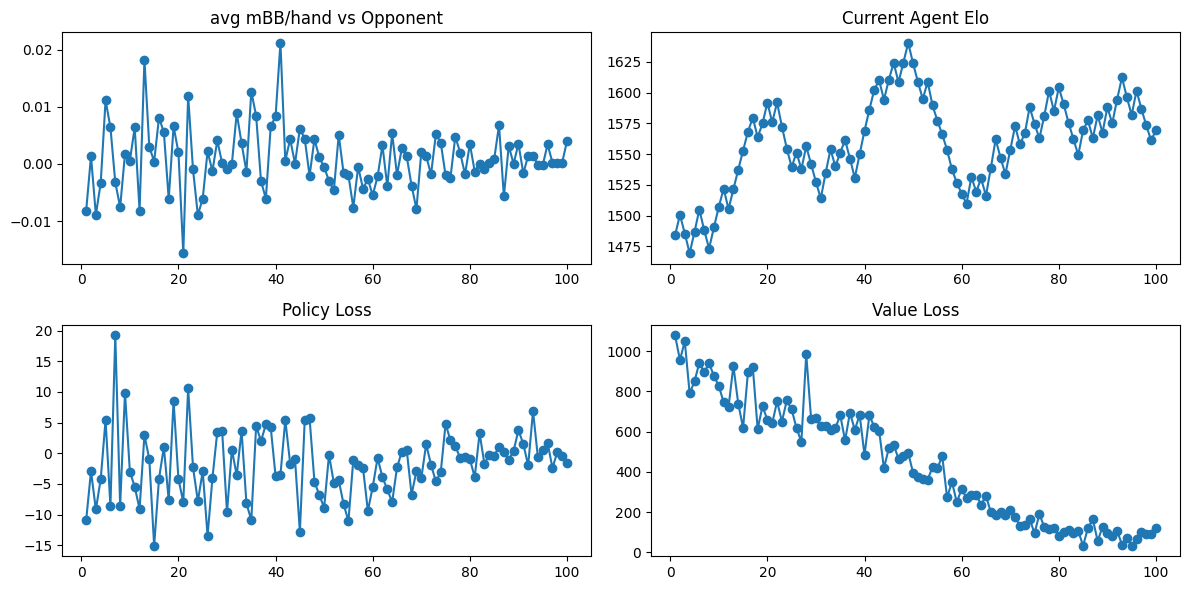

In [ ]:
writer.close()

# Plot
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.plot(cycle_numbers, avg_bb_list,   marker='o'); plt.title("avg mBB/hand vs Opponent")
plt.subplot(2,2,2)
plt.plot(cycle_numbers, elo_history,   marker='o'); plt.title("Current Agent Elo")
plt.subplot(2,2,3)
plt.plot(cycle_numbers, avg_pol_loss,  marker='o'); plt.title("Policy Loss")
plt.subplot(2,2,4)
plt.plot(cycle_numbers, avg_val_loss,  marker='o'); plt.title("Value Loss")
plt.tight_layout()
plt.show()